In [1]:
import openalexnet as oanet
import pandas as pd
import igraph as ig
import numpy as np
import matplotlib as mpl
import json

import nltk
nltk.download('wordnet')

from tqdm.auto import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /home/marlon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
filterData = {
    "is_paratext": "false",  # Only works, no paratexts (https://en.wikipedia.org/wiki/Paratext)
    "type": "journal-article", # Only journal articles
    "from_publication_date": "2020-01-01" # Published after 2020
}

searchString = "\"complex network\"" # works containing the string "complex networks"
sortData = ["cited_by_count:desc"] # sort by number of citations in descending order
entityType = "works"

openalex = oanet.OpenAlexAPI()

entities = openalex.getEntities(entityType,
                                filter=filterData,
                                search=searchString,
                                sort=sortData,
                                maxEntities=2500)

/tmp/ipykernel_57556/3070860993.py:13: UserWarning: Number of entities (2507) in OpenAlex is larger than the maximum allowed (2500). Only the first 2500 entities will be returned. You can set the maximum number of entities to be returned by setting maxEntities=yourNumber. To ignore this warning, set ignoreEntitiesLimitWarning=True.
  entities = openalex.getEntities(entityType,


In [3]:
k_DefaultKeptItems = [
    "id",
    "doi",
    "title",
    "display_name",
    "publication_year",
    "publication_date",
    "type",
    "authorships",
    "concepts",
    "host_venue",
    'abstract_inverted_index' 
]

network = oanet.createNetworks(entities,
                               networkTypes=["citation"],
                               simplifyNetworks=True,
                               keptAttributes = k_DefaultKeptItems,
                               showProgress=True)

network = network['citation']
network.summary()

Extracting edges and attributes:   0%|          | 0/2500 [00:00<?, ?it/s]

'IGRAPH D--T 2500 1854 -- \n+ attr: abstract_inverted_index (v), authorships (v), concepts (v), display_name (v), doi (v), host_venue (v), id (v), publication_date (v), publication_year (v), title (v), type (v)'

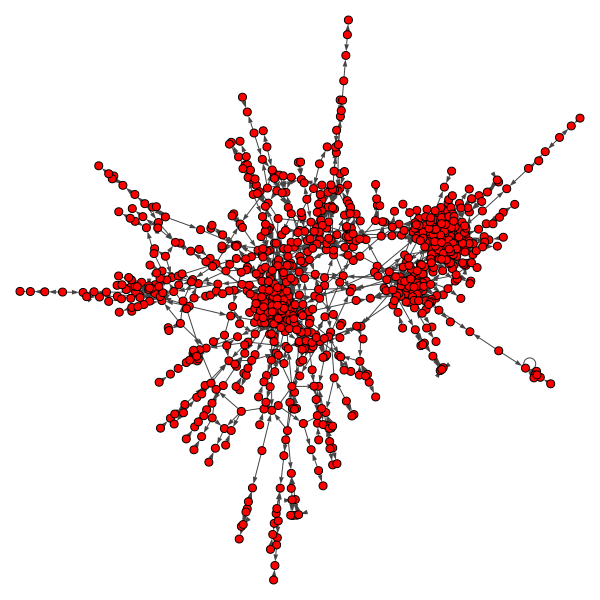

In [4]:
# connected_components = network.components("weak").giant()
# ig.plot(
#     connected_components,
#     vertex_size = 8.0,
#     edge_arrow_size = 0.5
# )

In [5]:
connected_components.summary()

'IGRAPH D--T 918 1643 -- \n+ attr: abstract_inverted_index (v), authorships (v), concepts (v), display_name (v), doi (v), host_venue (v), id (v), publication_date (v), publication_year (v), title (v), type (v)'

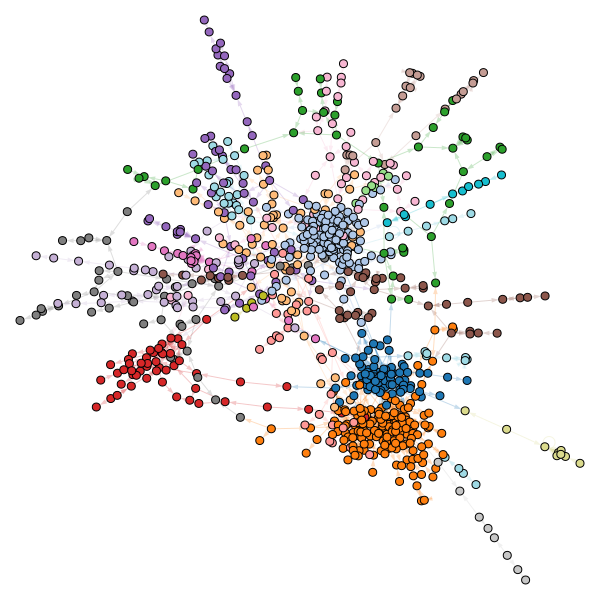

In [6]:
connected_components.vs['community'] = connected_components.as_undirected().community_multilevel().membership

vertex_colors = [mpl.cm.tab20(index) for index in connected_components.vs["community"]]
edge_colors = [vertex_colors[edge.source][:-1]+(0.25,) for edge in connected_components.es]

# labels = connected_components.vs["display_name"]

layout = connected_components.layout("fr")
ig.plot(connected_components,
        layout = layout,
#         vertex_label = labels,
#         vertex_label_size = 5,
        vertex_size = 8,
        vertex_color = vertex_colors,
        edge_arrow_size = 0.5,
        edge_color = edge_colors
        )

In [117]:
connected_components = network.components("weak").giant()
connected_components.vs['community'] = connected_components.as_undirected().community_multilevel().membership

In [118]:
n_vertex = connected_components.vcount()
for i in tqdm(range(n_vertex)):
    if (connected_components.vs[i]['abstract_inverted_index'] == 'null'):
        continue
   
    abstract_inverted_index = json.loads(connected_components.vs[i]['abstract_inverted_index'])
    abstract_index = {}
    for k, vlist in abstract_inverted_index.items():
        for v in vlist:
            abstract_index[v] = k

    connected_components.vs[i]['abstract_inverted_index'] = ' '.join(abstract_index[k] for k in sorted(abstract_index.keys()))

  0%|          | 0/918 [00:00<?, ?it/s]

In [119]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for i in tqdm(range(n_vertex)):
    if (connected_components.vs[i]['abstract_inverted_index'] == 'null'):
        continue

    abstract = connected_components.vs[i]['abstract_inverted_index']
    
    abstract = nltk.word_tokenize(abstract)
    abstract = [word.lower() for word in abstract if word.isalpha()]
    abstract = [w for w in abstract if not w.lower() in stop_words]
    
    connected_components.vs[i]['abstract_inverted_index'] = [lemmatizer.lemmatize(w) for w in abstract]

  0%|          | 0/918 [00:00<?, ?it/s]

In [120]:
counterAll = Counter()
countersCommunities = {}

for i in tqdm(range(n_vertex)):
    tokens = connected_components.vs[i]['abstract_inverted_index']

    community = connected_components.vs[i]['community']
    if community not in countersCommunities:
        countersCommunities[community] = Counter()
    countersCommunities[community].update(set(tokens))
    counterAll.update(set(tokens))

word_total = sum(counterAll.values())
word_frequency = {}
for w in tqdm(counterAll.keys()):
    word_frequency[w] = counterAll[w] / word_total
    
print('Amount of words:', word_total)
print('Amount of different words:', len(counterAll))

  0%|          | 0/918 [00:00<?, ?it/s]

  0%|          | 0/6184 [00:00<?, ?it/s]

Amount of words: 56258
Amount of different words: 6184


In [121]:
def n_grams(n_grams, connected_components, n_vertex, word_frequency):
    count = Counter()
    countCommunities = {}
    
    for i in tqdm(range(n_vertex)):
        abstract = connected_components.vs[i]['abstract_inverted_index']
        abstract = [w for w in abstract if word_frequency[w] > 0.0008]

        tokens = []
        for i in range(len(abstract)-n_grams):
            token = tuple(abstract[i:i+n_grams])
            tokens.append(token)
        
        community = connected_components.vs[i]['community']
        if community not in countCommunities:
            countCommunities[community] = Counter()
        countCommunities[community].update(set(tokens))
        count.update(set(tokens))
    
    return count, countCommunities

In [122]:
def alpha_communities(connected_components, communities):
    alpha_module = {}
    for c in communities:
        alpha_module[c] = connected_components.vs['community'].count(c)
    return alpha_module

In [123]:
def importance_index(connected_components, countersCommunities, counterAll):
    """
        N     = total number of papers in the network
        F_in  = relative in-community frequency
        F_out = relative out-community frequency
        I     = importance of keywords
    """

    N = n_vertex
    I = {}
    alpha_module = alpha_communities(connected_components, countersCommunities.keys())

    for community in tqdm(countersCommunities.keys()):
        I[community] = {}
        for word in countersCommunities[community].keys():
            F_in = countersCommunities[community][word] / alpha_module[community]
            F_out = (counterAll[word] - countersCommunities[community][word]) / (N - alpha_module[community])
            I[community][word] = F_in - F_out
        I[community] = dict(sorted(I[community].items(), key=lambda item: item[1], reverse=True))
        
    return I

In [124]:
count_nGrams, comunities_nGrams = n_grams(2, connected_components, n_vertex, word_frequency)
I = importance_index(connected_components, comunities_nGrams, count_nGrams)

  0%|          | 0/918 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [125]:
higher_indexes = {
        'community': [],
        'n_gram': [],
        'importance_index': []
    }
for community in comunities_nGrams.keys():
    for i in range(15):
        higher_indexes['community'].append(community)
        higher_indexes['n_gram'].append(list(I[community].keys())[i])
        higher_indexes['importance_index'].append(list(I[community].values())[i])
# higher_indexes

In [126]:
df = pd.DataFrame(higher_indexes)
df

,community,n_gram,importance_index
0,0,"(attack, certain)",0.031398
1,0,"(influence, model)",0.031398
2,0,"(coupled, network)",0.030187
3,0,"(show, effectiveness)",0.028950
4,0,"(also, show)",0.026555
...,...,...,...
280,5,"(spreading, dynamic)",0.156798
281,5,"(dynamic, complex)",0.152412
282,5,"(spreading, process)",0.148026
283,5,"(network, system)",0.134868
